### Sports Media Bias Analysis using GloVe Embeddings

#### Dataset Overview
- **Source**: GloVe Wikipedia 2014 + Gigaword 5
- **Composition**:
  - Wikipedia 2014 (articles covering history, science, culture)
  - Gigaword 5 (~5 billion words from major news articles focusing on current events, politics, economics)
- **Scale**:
  - 400,000 unique words/phrases
  - 6 billion tokens
  - 50, 100, 200, or 300-dimensional word vectors

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the GloVe embedding from file into dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Path to GloVe file
glove_path = 'glove.6B.300d.txt'
embeddings = load_glove_embeddings(glove_path)

# Test the loaded embedding by printing the vector for a word
# print(embeddings['football'])  # Example: vector for the word 'football'

In [3]:
# Find closest embeddings to a given embedding vector
def find_closest_embeddings(embedding, embeddings_dict):
    return sorted(
        embeddings_dict.keys(), 
        key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding)
    )

# Find 5 most similar words to 'football' (skip first result since it's 'football')
# print(find_closest_embeddings(embeddings["football"], embeddings)[1:6])

In [4]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Example: Checking similarity between 'football' and 'baseball'
vec_football = embeddings['football']
vec_baseball = embeddings['baseball']

similarity = cosine_similarity(vec_football, vec_baseball)
print(f"Cosine similarity between 'football' and 'baseball': {similarity:.3f}")

Cosine similarity between 'football' and 'baseball': 0.648


In [5]:
# Calculate embedding vector for multi-word team names
def get_team_embedding(team_name, glove_model):
    words = team_name.lower().split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    if not word_vectors:
        return None
    return np.mean(word_vectors, axis=0)

# Example usage
patriots_embedding = get_team_embedding("New England Patriots", embeddings)
jets_embedding = get_team_embedding("New York Jets", embeddings)

# Calculate similarity
similarity = cosine_similarity(patriots_embedding, jets_embedding)

print(f"Cosine similarity between 'New England Patriots' and 'New York Jets': {similarity:.3f}")


Cosine similarity between 'New England Patriots' and 'New York Jets': 0.720


In [6]:
# Analyze bias towards a team by comparing its embedding with evaluation words
def analyze_team_bias(team_name, eval_words, embeddings):
    team_embedding = get_team_embedding(team_name, embeddings)
    results = {}
    for word in eval_words:
        eval_embedding = embeddings[word]
        similarity = cosine_similarity(team_embedding, eval_embedding)
        results[word] = similarity
    return results

# Define credible and non-credible words
credible_words = [
    "trustworthy", "reliable", "factual", "accurate", "legitimate",
    "credible", "authentic", "professional", "authoritative"
]
non_credible_words = [
    "misleading", "biased", "unreliable", "fake", "exaggerated",
    "suspicious", "questionable", "controversial", "sensational"
]

# Combine both lists for evaluation
credibility_eval_words = credible_words + non_credible_words

#### Teams Analysis
Most Popular Teams: https://today.yougov.com/ratings/sports/popularity/sports-teams/all \
Least Popular Teams: https://www.actionnetwork.com/general/public-enemy-no-1-the-least-liked-sports-teams-in-the-us

In [7]:
# Teams Analysis (Popular vs Unpopular)
popular_teams = ["USA Olympic Team", "Chicago Cubs", 
                 "New York Yankees", "Los Angeles Lakers", 
                 "Chicago Bulls", "United States Women's National Soccer Team", 
                 "San Francisco 49ers", "Kansas City Chiefs", 
                 "New York Mets", "Buffalo Bills"]
unpopular_teams = ["Las Vegas Raiders", "Dalllas Stars", 
                   "Arizona Coyotes", "Philadelphia 76rs", 
                   "Chicago Bears", "Toronto Maple Leafs", 
                   "Vancouver Canucks", "Buffalo Sabres", 
                   "Toronto Raptors", "Denver Broncos"]


# Initialize results
popular_results = {}
unpopular_results = {}

# Analyze biases for teams
for team in popular_teams:
    popular_results[team] = analyze_team_bias(team, credibility_eval_words, embeddings)
for team in unpopular_teams:
    unpopular_results[team] = analyze_team_bias(team, credibility_eval_words, embeddings)

# Convert to DataFrames
df_popular = pd.DataFrame(popular_results)
df_unpopular = pd.DataFrame(unpopular_results)

In [8]:
# Calculate means
popular_means = df_popular.mean(axis=1)
unpopular_means = df_unpopular.mean(axis=1)
difference = popular_means - unpopular_means

# Create and sort separate DataFrames for credible and non-credible words
credible_df = pd.DataFrame({
    'Popular Teams': popular_means[credible_words],
    'Unpopular Teams': unpopular_means[credible_words],
    'Difference': difference[credible_words]
}).round(3).sort_values('Difference', ascending=False)

non_credible_df = pd.DataFrame({
    'Popular Teams': popular_means[non_credible_words],
    'Unpopular Teams': unpopular_means[non_credible_words],
    'Difference': difference[non_credible_words]
}).round(3).sort_values('Difference', ascending=False)

# Print formatted tables
print("\nCREDIBLE WORDS COMPARISON:")
print("=" * 70)
print(f"{'Word':<15} {'Popular':>10} {'Unpopular':>12} {'Difference':>12}")
print("-" * 70)
for word in credible_df.index:
    print(f"{word:<15} {credible_df.loc[word, 'Popular Teams']:>10.3f} "
          f"{credible_df.loc[word, 'Unpopular Teams']:>12.3f} "
          f"{credible_df.loc[word, 'Difference']:>12.3f}")
print("=" * 70)

print("\nNON-CREDIBLE WORDS COMPARISON:")
print("=" * 70)
print(f"{'Word':<15} {'Popular':>10} {'Unpopular':>12} {'Difference':>12}")
print("-" * 70)
for word in non_credible_df.index:
    print(f"{word:<15} {non_credible_df.loc[word, 'Popular Teams']:>10.3f} "
          f"{non_credible_df.loc[word, 'Unpopular Teams']:>12.3f} "
          f"{non_credible_df.loc[word, 'Difference']:>12.3f}")
print("=" * 70)


CREDIBLE WORDS COMPARISON:
Word               Popular    Unpopular   Difference
----------------------------------------------------------------------
professional         0.262        0.168        0.094
authoritative       -0.027       -0.111        0.084
legitimate           0.092        0.007        0.084
reliable             0.065       -0.008        0.073
credible             0.025       -0.019        0.044
accurate             0.040       -0.005        0.044
authentic            0.046        0.006        0.040
trustworthy         -0.076       -0.091        0.015
factual             -0.062       -0.057       -0.005

NON-CREDIBLE WORDS COMPARISON:
Word               Popular    Unpopular   Difference
----------------------------------------------------------------------
controversial        0.182        0.084        0.098
fake                 0.074        0.022        0.051
biased              -0.005       -0.052        0.048
misleading           0.007       -0.034        0.041
que

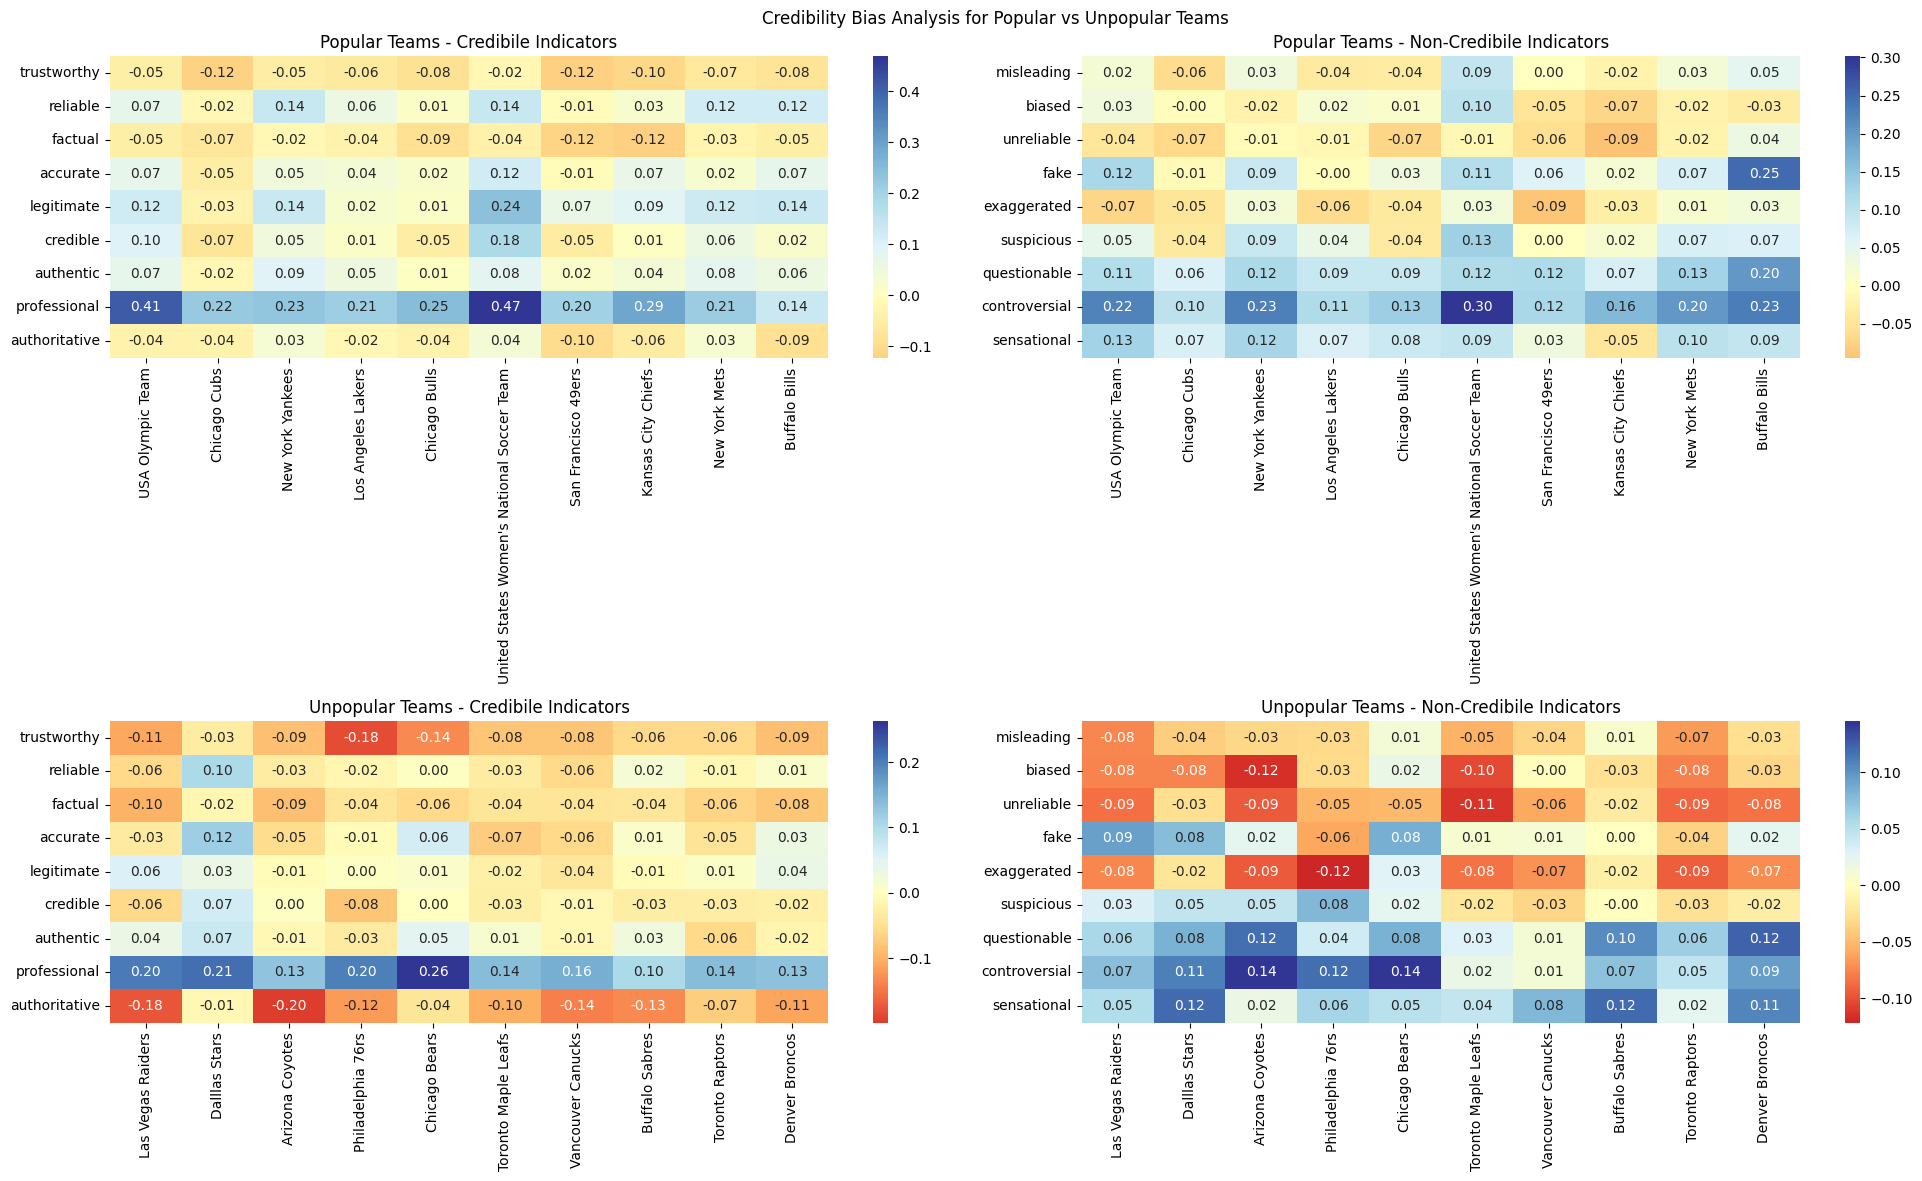

In [9]:
# Create separate DataFrames for positive and negative words
df_popular_credible = df_popular.loc[credible_words]
df_popular_non_credible = df_popular.loc[non_credible_words]
df_unpopular_credible = df_unpopular.loc[credible_words]
df_unpopular_non_credible = df_unpopular.loc[non_credible_words]

# Create visualization with 4 subplots
plt.figure(figsize=(20, 12))
plt.suptitle('Credibility Bias Analysis for Popular vs Unpopular Teams')

# Popular Teams - Credible Words
plt.subplot(2, 2, 1)
sns.heatmap(df_popular_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Popular Teams - Credibile Indicators')

# Popular Teams - Non-Credible Words
plt.subplot(2, 2, 2)
sns.heatmap(df_popular_non_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Popular Teams - Non-Credibile Indicators')

# Unpopular Teams - Credible Words
plt.subplot(2, 2, 3)
sns.heatmap(df_unpopular_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Unpopular Teams - Credibile Indicators')

# Unpopular Teams - Non-Credible Words
plt.subplot(2, 2, 4)
sns.heatmap(df_unpopular_non_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Unpopular Teams - Non-Credibile Indicators')

plt.tight_layout()
plt.show()

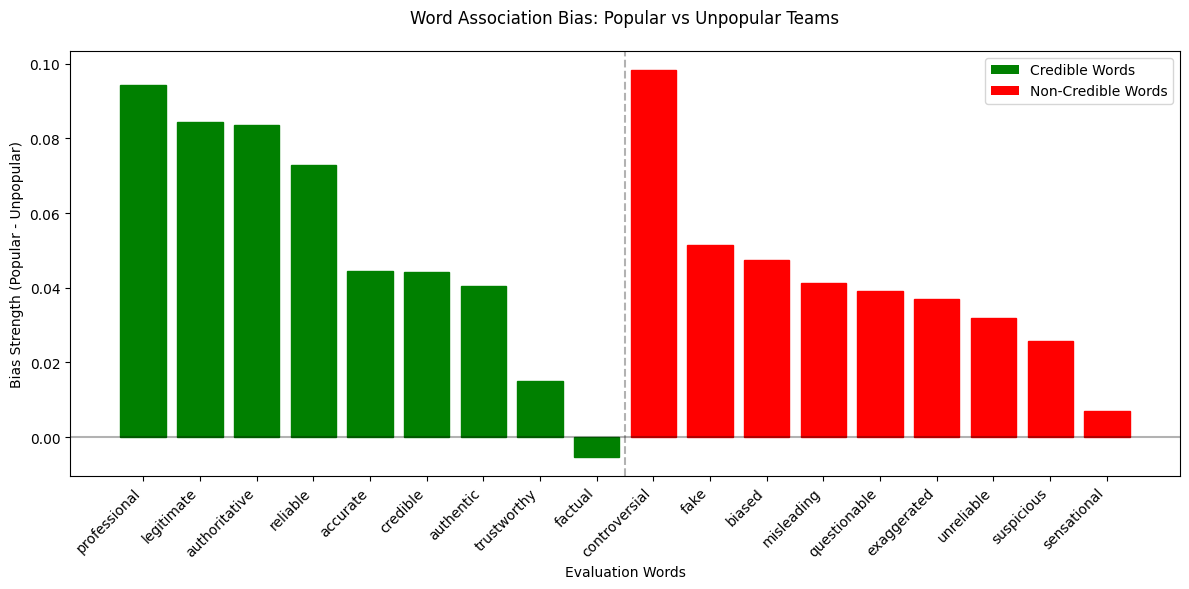

In [10]:
# Calculate mean scores for each word
popular_means = df_popular.mean(axis=1)
unpopular_means = df_unpopular.mean(axis=1)

# Calculate differences (popular - unpopular)
differences = popular_means - unpopular_means

# Calculate differences for credible and non-credible words separately
credible_differences = differences[credible_words].sort_values(ascending=False)
non_credible_differences = differences[non_credible_words].sort_values(ascending=False)

# Combine sorted differences
sorted_differences = pd.concat([credible_differences, non_credible_differences])

# Create visualization
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_differences)), sorted_differences)

# Color the bars based on word type
for i, bar in enumerate(bars):
    if i < len(credible_words):
        bar.set_color('green')
    else:
        bar.set_color('red')

# Add labels and title
plt.title('Word Association Bias: Popular vs Unpopular Teams', pad=20)
plt.xlabel('Evaluation Words')
plt.ylabel('Bias Strength (Popular - Unpopular)')
plt.xticks(range(len(sorted_differences)), sorted_differences.index, rotation=45, ha='right')

# Add legend for word types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Credible Words'),
    Patch(facecolor='red', label='Non-Credible Words')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add vertical line to separate credible and non-credible words
plt.axvline(x=len(credible_words)-0.5, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

##### Results

Each of the credible and non-credible words (except 'factual') are more associated with popular sports teams.

#### Sports Analysis

Most/Least Popular Sports: https://www.topendsports.com/world/lists/popular-sport/analysis.htm

In [11]:
# Sports Analysis (Popular vs Unpopular)
popular_sports = ["Football", "Basketball", 
                 "Baseball", "Soccer", 
                 "Cricket", "Tennis",
                 "Volleyball"]
unpopular_sports = ["Curling", "Handball", 
                   "Kabaddi", "Bowling", 
                   "Boat Racing", "Swimming",
                   "Boxing"]

# Initialize results
popular_results = {}
unpopular_results = {}

# Analyze biases for teams
for sport in popular_sports:
    popular_results[sport] = analyze_team_bias(sport, credibility_eval_words, embeddings)
for sport in unpopular_sports:
    unpopular_results[sport] = analyze_team_bias(sport, credibility_eval_words, embeddings)

# Convert to DataFrames
df_popular = pd.DataFrame(popular_results)
df_unpopular = pd.DataFrame(unpopular_results)

In [12]:
# Calculate means
popular_means = df_popular.mean(axis=1)
unpopular_means = df_unpopular.mean(axis=1)
difference = popular_means - unpopular_means

# Create and sort separate DataFrames for credible and non-credible words
credible_df = pd.DataFrame({
    'Popular Sports': popular_means[credible_words],
    'Unpopular Sports': unpopular_means[credible_words],
    'Difference': difference[credible_words]
}).round(3).sort_values('Difference', ascending=False)

non_credible_df = pd.DataFrame({
    'Popular Sports': popular_means[non_credible_words],
    'Unpopular Sports': unpopular_means[non_credible_words],
    'Difference': difference[non_credible_words]
}).round(3).sort_values('Difference', ascending=False)

# Print formatted tables
print("\nCREDIBLE WORDS COMPARISON:")
print("=" * 70)
print(f"{'Word':<15} {'Popular':>10} {'Unpopular':>12} {'Difference':>12}")
print("-" * 70)
for word in credible_df.index:
    print(f"{word:<15} {credible_df.loc[word, 'Popular Sports']:>10.3f} "
          f"{credible_df.loc[word, 'Unpopular Sports']:>12.3f} "
          f"{credible_df.loc[word, 'Difference']:>12.3f}")
print("=" * 70)

print("\nNON-CREDIBLE WORDS COMPARISON:")
print("=" * 70)
print(f"{'Word':<15} {'Popular':>10} {'Unpopular':>12} {'Difference':>12}")
print("-" * 70)
for word in non_credible_df.index:
    print(f"{word:<15} {non_credible_df.loc[word, 'Popular Sports']:>10.3f} "
          f"{non_credible_df.loc[word, 'Unpopular Sports']:>12.3f} "
          f"{non_credible_df.loc[word, 'Difference']:>12.3f}")
print("=" * 70)


CREDIBLE WORDS COMPARISON:
Word               Popular    Unpopular   Difference
----------------------------------------------------------------------
professional         0.412        0.254        0.158
legitimate           0.078        0.028        0.049
authoritative        0.014       -0.026        0.040
reliable             0.008       -0.017        0.025
accurate             0.063        0.055        0.009
credible            -0.012       -0.016        0.005
authentic            0.028        0.036       -0.008
trustworthy         -0.071       -0.049       -0.022
factual             -0.029        0.002       -0.031

NON-CREDIBLE WORDS COMPARISON:
Word               Popular    Unpopular   Difference
----------------------------------------------------------------------
controversial        0.132        0.077        0.055
biased               0.039        0.009        0.030
questionable         0.036        0.015        0.020
fake                 0.043        0.023        0.020
sus

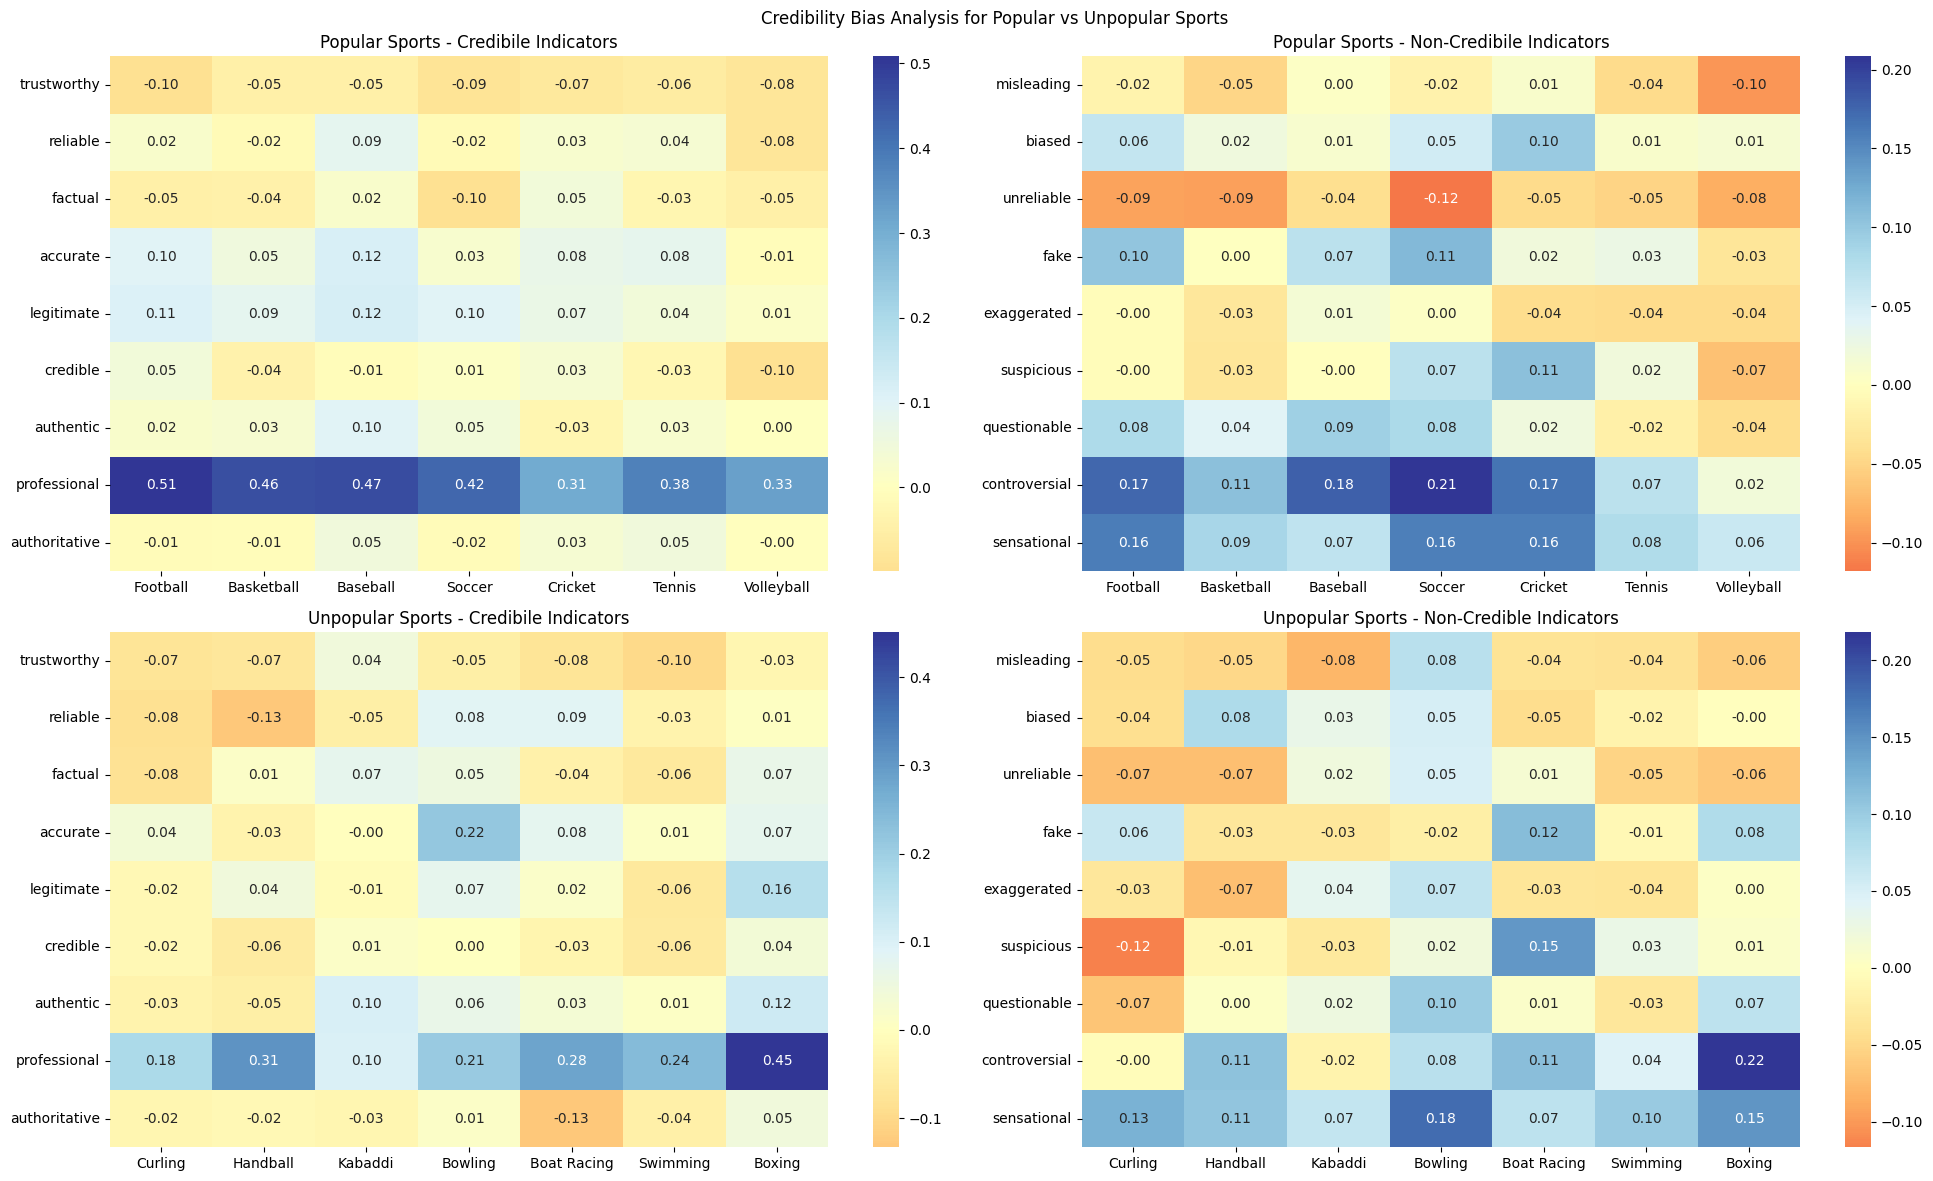

In [13]:
# Create separate DataFrames for positive and negative words
df_popular_credible = df_popular.loc[credible_words]
df_popular_non_credible = df_popular.loc[non_credible_words]
df_unpopular_credible = df_unpopular.loc[credible_words]
df_unpopular_non_credible = df_unpopular.loc[non_credible_words]

# Create visualization with 4 subplots
plt.figure(figsize=(20, 12))
plt.suptitle('Credibility Bias Analysis for Popular vs Unpopular Sports')

# Popular Sports - Credible Words
plt.subplot(2, 2, 1)
sns.heatmap(df_popular_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Popular Sports - Credibile Indicators')

# Popular Sports - Non-Credible Words
plt.subplot(2, 2, 2)
sns.heatmap(df_popular_non_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Popular Sports - Non-Credibile Indicators')

# Unpopular Sports - Credible Words
plt.subplot(2, 2, 3)
sns.heatmap(df_unpopular_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Unpopular Sports - Credibile Indicators')

# Unpopular Sports - Non-Credible Words
plt.subplot(2, 2, 4)
sns.heatmap(df_unpopular_non_credible, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Unpopular Sports - Non-Credible Indicators')

plt.tight_layout()
plt.show()

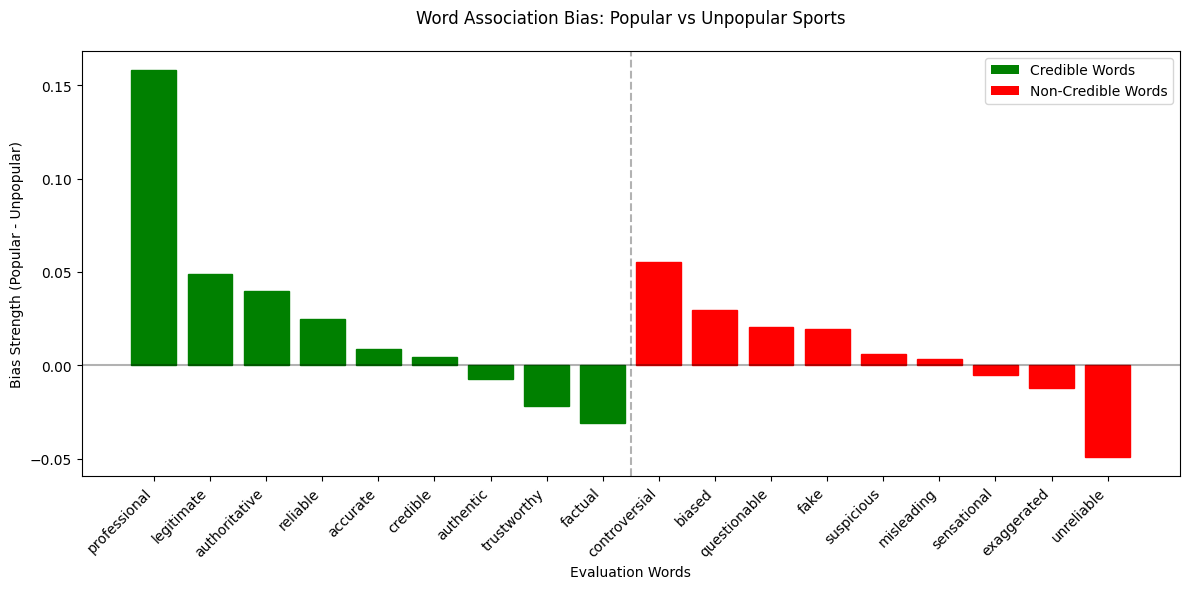

In [14]:
# Calculate mean scores for each word
popular_means = df_popular.mean(axis=1)
unpopular_means = df_unpopular.mean(axis=1)

# Calculate differences (popular - unpopular)
differences = popular_means - unpopular_means

# Calculate differences for credible and non-credible words separately
credible_differences = differences[credible_words].sort_values(ascending=False)
non_credible_differences = differences[non_credible_words].sort_values(ascending=False)

# Combine sorted differences
sorted_differences = pd.concat([credible_differences, non_credible_differences])

# Create visualization
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_differences)), sorted_differences)

# Color the bars based on word type
for i, bar in enumerate(bars):
    if i < len(credible_words):
        bar.set_color('green')
    else:
        bar.set_color('red')

# Add labels and title
plt.title('Word Association Bias: Popular vs Unpopular Sports', pad=20)
plt.xlabel('Evaluation Words')
plt.ylabel('Bias Strength (Popular - Unpopular)')
plt.xticks(range(len(sorted_differences)), sorted_differences.index, rotation=45, ha='right')

# Add legend for word types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Credible Words'),
    Patch(facecolor='red', label='Non-Credible Words')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add vertical line to separate credible and non-credible words
plt.axvline(x=len(credible_words)-0.5, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

##### Results

A mix of credible and non-credible words are associated with btoh popular and unpopular sports teams. The largest association of 'professional' makes sense since the popular sports are more likely to be referenced when talking about professional sports since theyare moie likely to have professional leagues.

#### Other Analysis

- Market Size (Big Market Teams versus Small Market Teams)
- Sports Positions (NFL: QB versus Linebacker)
- Player Popularity (Famous Players versus Unknown Players)